In [231]:
import nibabel as nib
import pyvista as pv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import utils_plotting, utils_VAT

import warnings
warnings.filterwarnings('ignore')

# load basal ganglia nuclei meshes
GP_meshes       = utils_VAT.load_GP_meshes()
STN_meshes      = utils_VAT.load_STN_meshes()

# color codes for basal ganglia nuclei
colors          = {}
colors["stn"]   = "sandybrown"
colors["gpi"]   = "lightgreen"
colors["gpe"]   = "turquoise"

clinical_data   = pd.read_csv("clinical_data.csv")

# 1. Import E-Fields of Patients

In [234]:
data_efield = pd.DataFrame(columns=["patient", "hemisphere", "coordinates", "vector_magnitude"])

for p_id in range(25):
    
    patient = "P"+str(p_id+1)
    
    for hemisphere in ["right", "left"]:
        try:
            VAT, efield = utils_VAT.load_efields_for_patients(path="data_VAT/"+patient+"/vat_efield_" + hemisphere + ".nii")
            row         = {"patient": patient, "hemisphere": hemisphere, 
                           "coordinates": efield["coordinates"], 
                           "vector_magnitude": efield["vector_magnitude"]}
            
            data_efield.loc[len(data_efield)] = row
        except:
            print("Patient " + patient + " - " + hemisphere + " hemisphere e-field was not found in the directory...")

Patient P10 - right hemisphere e-field was not found in the directory...
Patient P10 - left hemisphere e-field was not found in the directory...
Patient P14 - left hemisphere e-field was not found in the directory...
Patient P19 - right hemisphere e-field was not found in the directory...
Patient P19 - left hemisphere e-field was not found in the directory...
Patient P21 - right hemisphere e-field was not found in the directory...
Patient P21 - left hemisphere e-field was not found in the directory...
Patient P25 - right hemisphere e-field was not found in the directory...
Patient P25 - left hemisphere e-field was not found in the directory...


# 2. Measure Voxel-Wise E-Fields

In [236]:
# threshold for voxels that were at least covered by 30% of E-fields across patients with a vector magnitude above 150 V/m
N_patient                                = data_efield.patient.nunique()
threshold                                = 30 # %
voxel_size                               = 0.25

# filter non-zero e-field vector magnitudes, in the previous step we set all e-field points having vector
# magnitude less than 150 V/m to 0, in this step, we filter them out
data_efield_filtered                     = data_efield.explode(["coordinates", "vector_magnitude"])
data_efield_filtered                     = data_efield_filtered[data_efield_filtered["vector_magnitude"] > 0]

# expand coordinates into separate columns
data_efield_filtered[["x", "y", "z"]]    = pd.DataFrame(data_efield_filtered["coordinates"].tolist(), index=data_efield_filtered.index)
data_efield_filtered                     = data_efield_filtered[["patient", "hemisphere", "x", "y", "z", "vector_magnitude"]] 

# we assign each e-field position to a voxel
data_efield_filtered                     = utils_VAT.assign_efields_to_voxels_new(data_efield_filtered, voxel_size=voxel_size)
# we take the mean of all the e-fields belonging to the same voxel by taking the mean for each patient and hemisphere separately
data_aggregated_efield                   = utils_VAT.aggregate_voxels(data_efield_filtered)

# group by coordinates and hemisphere, and count how many patients acceptable e-field in the selected voxel
valid_voxels                             = data_aggregated_efield.groupby(['x_voxel', 'y_voxel', 'z_voxel', 'hemisphere'])['patient'].nunique().reset_index()
# calculate the percentage of patients having an e-field of more than 150 V/m for each voxel
valid_voxels['patient_coverage']         = (valid_voxels['patient'] / N_patient) * 100
valid_voxels                             = valid_voxels[valid_voxels.patient_coverage>=threshold]

# 3. Measure Voxel-Wise Correlation Between BFMDRS Improvement and E-Field Magnitude 

In [237]:
filtered_EFields = data_aggregated_efield.merge(valid_voxels[['x_voxel', 'y_voxel', 'z_voxel', 'hemisphere']], 
                                           on=['x_voxel', 'y_voxel', 'z_voxel', 'hemisphere'], how='inner')
filtered_EFields = filtered_EFields.merge(clinical_data, on='patient', how='left')
data_corr        = utils_VAT.calculate_spearman_correlation(filtered_EFields)

# 4. Plotting

In [238]:
R_plane, L_plane = utils_VAT.extract_plane_correlation(data_corr, plane_x="x", plane_y="y", plane_value=np.nan)

<Figure size 640x480 with 0 Axes>

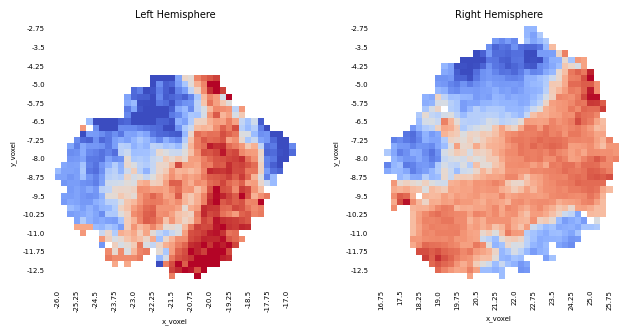

In [239]:
# Plotting as a heatmap
plt  = utils_plotting.get_figure_template()
ax_L = plt.subplot2grid((75, 70), (0, 0) , colspan=30, rowspan=30)
ax_R = plt.subplot2grid((75, 70), (0, 40), colspan=30, rowspan=30)

ax_L = sns.heatmap(L_plane, cmap='coolwarm', annot=False, fmt=".2f", annot_kws={'size': 5}, cbar=False, vmin=-0.5, vmax=0.5, ax=ax_L)
ax_L.set_title("Left Hemisphere", fontsize=7)
utils_plotting.set_axis(ax_L)

ax_R = sns.heatmap(R_plane, cmap='coolwarm', annot=False, fmt=".2f", annot_kws={'size': 5}, cbar=False, vmin=-0.5, vmax=0.5, ax=ax_R)
ax_R.set_title("Right Hemisphere", fontsize=7)
utils_plotting.set_axis(ax_R)

#plt.savefig('heatmap.svg', dpi=300)

In [259]:
data_corr[(data_corr.correlation>=0) & (data_corr.pvalue<=0.05)].correlation.min()

0.5549450549450549

In [263]:
data_corr[(data_corr.correlation<0) & (data_corr.pvalue<=0.05)].correlation.max()

-0.5604395604395606